In [1]:
# use tf_env conda env
import sys
sys.path.append('../source')
import get_data, analysis, utils
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
from scipy import stats

%config InlineBackend.figure_format = 'retina'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

fig_out_dir = '../figures/figure2'

# Read in TCGA and ICGC data

In [ ]:
# NOTE: this data needs to be downloaded from TCGA, follow instructions in ./download_data/download_external.sh

# TCGA data, methylation is quantile normalized
all_mut_w_age_df, illumina_cpg_locs_df, all_methyl_age_df_t, _, _ = get_data.read_tcga_data()

In [3]:
# NOTE: this data needs to be downloaded from ICGC/PCAWG, follow instructions in ./download_data/download_external.sh


# icgc data, methylation is also quantile normalized
# qnorm 
icgc_mut_w_age_df, illumina_cpg_locs_df, icgc_methyl_age_df_t, _, _ = get_data.read_icgc_data()
# read in the annotated version of the icgc data, annotated with pyfaidx
icgc_mut_w_age_df = pd.read_parquet('../data/icgc/icgc_mut_w_age_annot_df.parquet')

reading in data
Got mutations and metadata, reading methylation
Got methylation, transposing
Done


# Fig 1a

      Mutation class  mut_freq
0                CpG  0.135077
1      Expected\nCpG  0.009021
2            non-CpG  0.864923
3  Expected\nnon-CpG  0.990979


/cellar/users/zkoch/somAge/notebooks/../source/analysis.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  p = sns.barplot(x=cpg_mut_freq['Mutation class'], y=cpg_mut_freq['mut_freq'], ax=axes, palette=['white', 'black','white', 'black' ], edgecolor='black', errorbar=None)


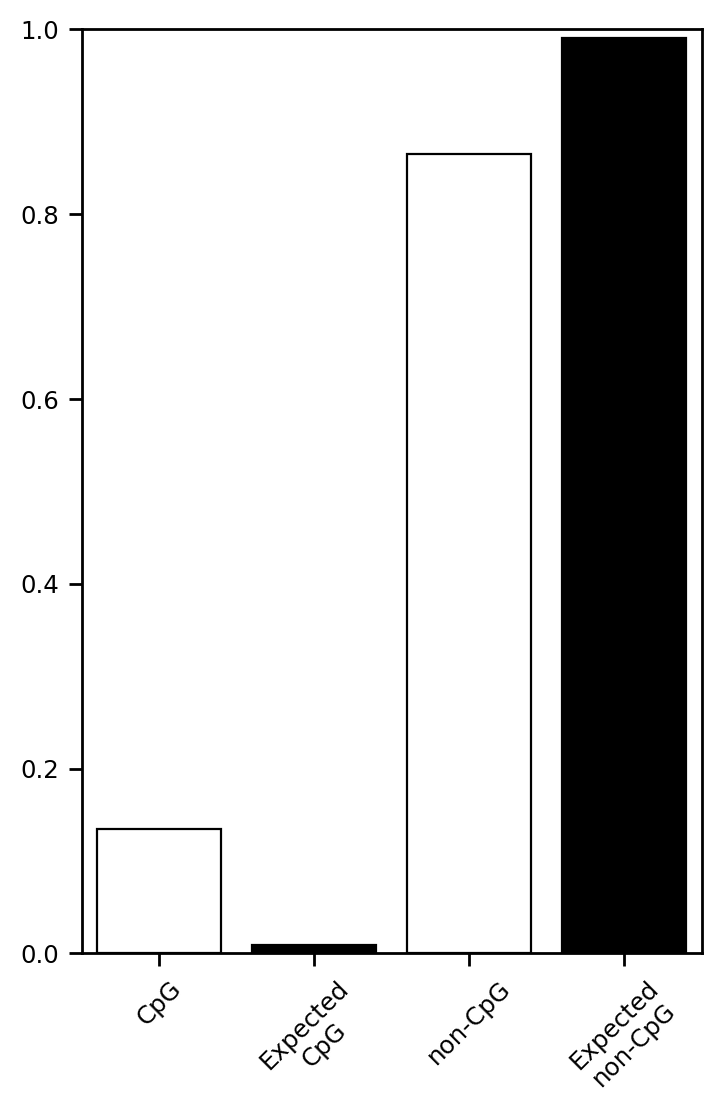

In [4]:
cpg_mut_freq = analysis.plot_mutations_distributions(
    icgc_mut_w_age_df, illumina_cpg_locs_df, icgc_methyl_age_df_t
    )
plt.savefig(os.path.join(fig_out_dir, 'figure2a.svg'), dpi = 300, format = 'svg')

# Fig 1c

In [5]:
mut_in_measured_cpg_df = utils.join_df_with_illum_cpg(all_mut_w_age_df, illumina_cpg_locs_df, all_methyl_age_df_t)
mutated_atleast_once = mut_in_measured_cpg_df['#id'].to_list()
never_mutated = list(set(all_methyl_age_df_t.iloc[:,3:].columns) - set(mutated_atleast_once))

mut_in_measured_cpg_df['methyl_fraction'] = utils.get_methyl_fractions(mut_in_measured_cpg_df, all_methyl_age_df_t)
mut_in_measured_cpg_df['avg_methyl_frac'] = all_methyl_age_df_t[mut_in_measured_cpg_df['#id']].mean().values
mut_in_measured_cpg_df['difference'] = mut_in_measured_cpg_df['methyl_fraction'] - mut_in_measured_cpg_df['avg_methyl_frac']

Number of mutations in measured CpG sites: 8037
selected 1000 mtuations events with largest DNA_VAF, minimum DNA_VAF: 0.53


/cellar/users/zkoch/somAge/notebooks/../source/analysis.py:70: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  non_mutated_methyl_df_t.mean(axis=0)
/cellar/users/zkoch/somAge/notebooks/../source/analysis.py:74: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  to_plot_df['Type'] = ['Non mutated CpGs'] * len(mutation_in_measured_cpg_df['avg_methyl_frac']) +  ['Mutated CpGs'] * len(mutation_in_measured_cpg_df['methyl_fraction']) + ['Site of no CpG mutation'] * len(non_mutated_methyl_df_t.mean(axis=0))


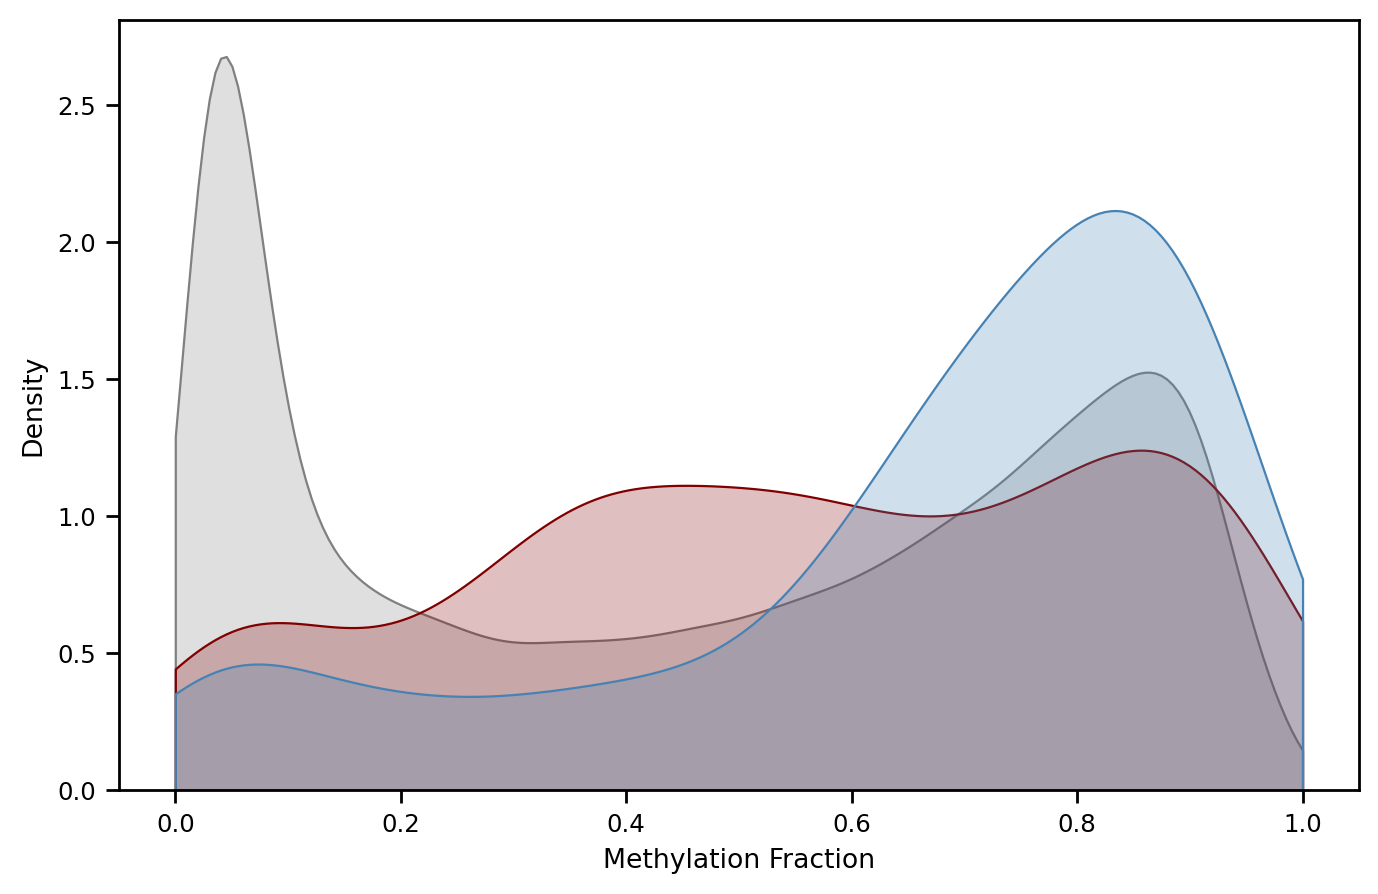

In [6]:
to_plot_df = analysis.compare_mf_mutated_sample_vs_avg(mut_in_measured_cpg_df, all_methyl_age_df_t)
plt.savefig(os.path.join(fig_out_dir, 'figure2c.svg'), dpi = 300, format = 'svg')

# Fig 1d

/tmp/ipykernel_102621/3712839161.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data = mut_in_measured_cpg_df, x = 'VAF_bin', y = 'difference',  palette = 'Reds', density_norm = 'area', common_norm=True, cut = 0)


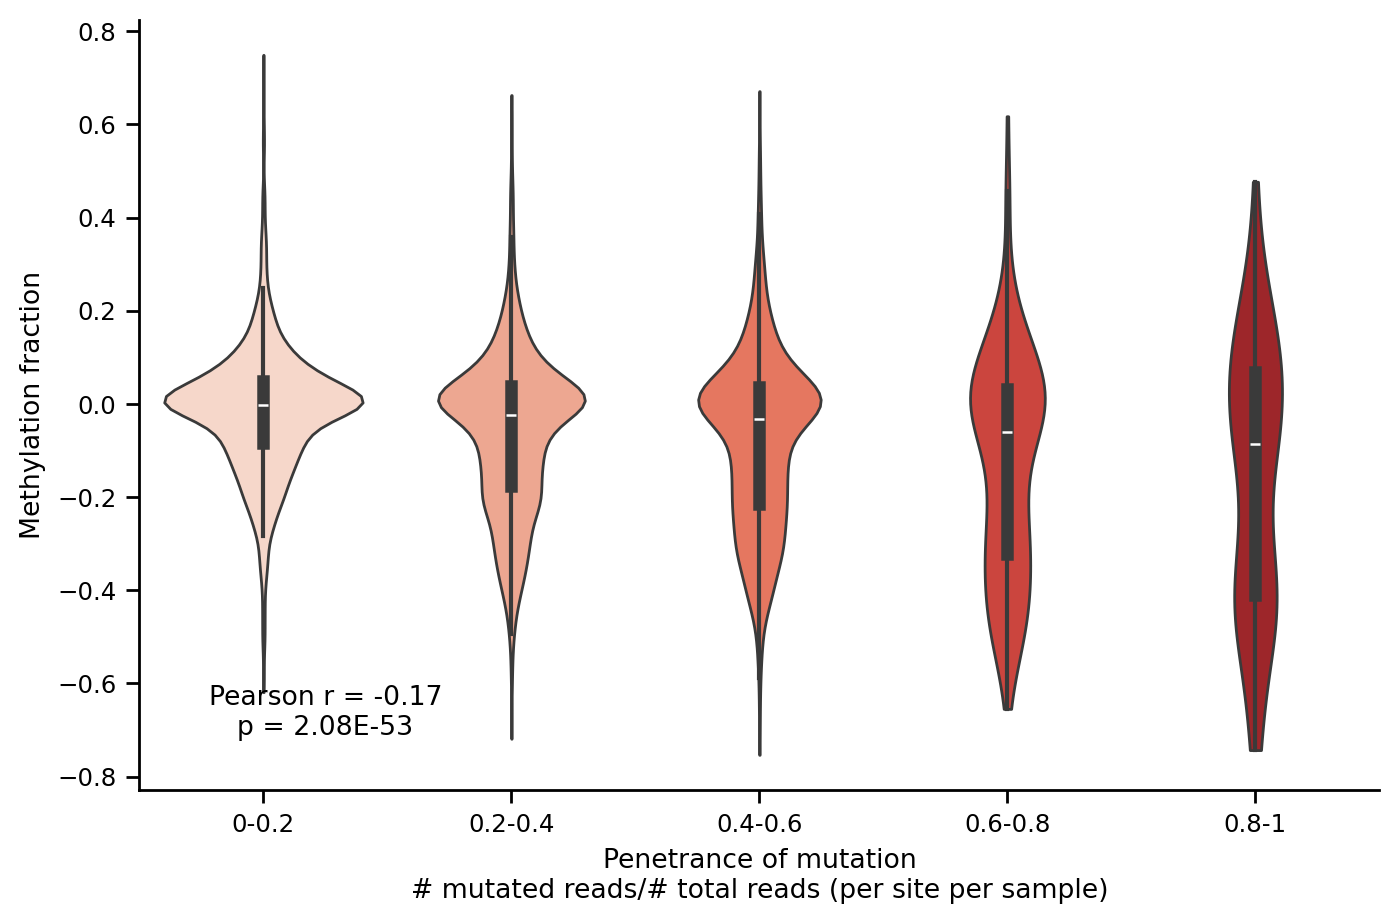

In [7]:
# bin mut_in_measured_cpg_w_methyl_age_df['DNA_VAF'] into 5 equal width bins from 0 to 1
mut_in_measured_cpg_df['VAF_bin'] = pd.cut(
                mut_in_measured_cpg_df['DNA_VAF'],
                bins = 5,
                labels = ['0-0.2', '0.2-0.4', '0.4-0.6', '0.6-0.8', '0.8-1']
                )

# new way
sns.set_context('paper')
# make bigger figure
plt.figure(figsize=(8,5), dpi=100)
sns.violinplot(data = mut_in_measured_cpg_df, x = 'VAF_bin', y = 'difference',  palette = 'Reds', density_norm = 'area', common_norm=True, cut = 0)
plt.ylabel('Methylation fraction')
plt.xlabel('Penetrance of mutation\n# mutated reads/# total reads (per site per sample)')
# add pearson correlation coefficient and pvalue to plot
p_val = pearsonr(mut_in_measured_cpg_df['DNA_VAF'], mut_in_measured_cpg_df['difference']).pvalue
r = pearsonr(mut_in_measured_cpg_df['DNA_VAF'], mut_in_measured_cpg_df['difference']).statistic

plt.text(
    0.15, 0.1, f'Pearson r = {round(r,3)}\np = {p_val:.2E}', horizontalalignment='center', verticalalignment='center', transform = plt.gca().transAxes
    )
    
sns.despine()
plt.savefig(os.path.join(fig_out_dir, 'figure2d.svg'), dpi = 300, format = 'svg')
